In [1]:
%matplotlib widget

import sys
import os
import time
import math as math
from datetime import datetime
import pickle 
import numpy as np
import astropy as ast
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.table import Table, hstack, vstack, Column
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import Angle
from astropy.time import Time
from photutils.aperture import EllipticalAnnulus, aperture_photometry
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate
import scipy.constants
import scipy.special
import scipy.misc
from scipy import integrate
from scipy.optimize import curve_fit
import scipy.interpolate
from scipy.interpolate import CubicSpline
import glob2
import shutil
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from tqdm.notebook import tqdm as tqdm

import cv2

import Utility3_4 as ut

pi = sp.constants.pi
k= sp.constants.k
q_e = sp.constants.e

DimY = 1096
DimX = 1936

Offset = 2 #ADU Blacklevel Offset

Gain = 2.398
SigmaGain = 0.069

DisectString = '\1/'
BackSlash = DisectString[0]
ForwardSlash = '/'

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
#Loading in Master Hots Array
HotsArray = np.loadtxt('SteadyStateDataSets/MasterHotsArray.csv', delimiter=',')

SetNamesList = ['X0_Y0','X0_YM1','X0_YM2','X0_YM3','X0_YP1','X0_YP2','X0_YP3','XM2_Y0','XM2_YM1','XM2_YP1','XP2_Y0','XP2_YM1','XP2_YP1','XP4_Y0']

#Make the Offset Dictionary
OffsetDict = {}

for SetName in SetNamesList:
    Offset = 2
    OffsetDict.update({SetName:Offset})

#This frame has an offset of 3 for some reason. MeanFrameMedian=5.0 for this mosaic position where every other position has 4.0.
OffsetDict.update({'XM2_Y0':3}) 

#----------------------------------------------------------------------------------------------------------------------

#Loading in Saved Dictionaries
with open('MeanExpTimeDict.pkl', 'rb') as f:
    MeanExpTimeDict = pickle.load(f)
    
with open('NumFrameCountDict.pkl', 'rb') as f:
    NumFrameCountDict = pickle.load(f)
    
with open('FrameCountDict.pkl', 'rb') as f:
    FrameCountDict = pickle.load(f)

#Loading in the Final Frame Translation Dictionary
with open('TranslateX_Dict_GD4.pkl', 'rb') as f:
    TranslateX_Dict_GD4 = pickle.load(f)
        
with open('TranslateY_Dict_GD4.pkl', 'rb') as f:
    TranslateY_Dict_GD4 = pickle.load(f)

#----------------------------------------------------------------------------------------------------------------------

#Making Dictionaries
SumSignalFrameDict = {}
ErrSumSignalFrameDict = {}

SumDarkSubSignalFrameDict = {}
ErrSumDarkSubSignalFrameDict = {}

MeanDarkFrameDict = {}
SumDarkFrameDict = {}

HotsArrayDict = {}
CoordsDict = {}

for SetName in tqdm(SetNamesList):
    
    #making flux frame and error flux frame dictionaries
    LoadDirectory = 'SteadyStateDataSets/' + SetName + '/'
    
    #Loading in mean dark frames (in units of ADU)
    DarkFrameName = 'MeanCS_Dark'
    MeanDarkFrame = np.loadtxt(LoadDirectory + DarkFrameName + '.csv', delimiter=',')
    #Making sum dark frame (in units of ADU)
    MeanDarkFrame = (MeanDarkFrame - OffsetDict[SetName])*Gain #Convert from ADU to e-, and correcting for Offset
    Multiplier = FrameCountDict[SetName]
    SumDarkFrame = Multiplier*MeanDarkFrame
    
    
    #Loading in the non-dark subtracted sum signal frames (Tiles)
    SumSignalFrame = np.loadtxt(LoadDirectory + 'PrelimNoDarkSubSumSignalFrame4' + '.csv', delimiter=',')
    ErrorSumSignalFrame = np.loadtxt(LoadDirectory + 'PrelimNoDarkSubErrorSumSignalFrame4' + '.csv', delimiter=',')
    
    #Loading in the dark subtracted sum signal frames (Tiles)
    SumDarkSubSignalFrame = np.loadtxt(LoadDirectory + 'PrelimDarkSubSumSignalFrame4' + '.csv', delimiter=',')
    ErrorSumDarkSubSignalFrame = np.loadtxt(LoadDirectory + 'PrelimDarkSubErrorSumSignalFrame4' + '.csv', delimiter=',')
    
    MeanDarkFrameDict.update({SetName:MeanDarkFrame})
    SumDarkFrameDict.update({SetName:SumDarkFrame})
    
    SumSignalFrameDict.update({SetName:SumSignalFrame})
    ErrSumSignalFrameDict.update({SetName:ErrorSumSignalFrame})
    
    SumDarkSubSignalFrameDict.update({SetName:SumDarkSubSignalFrame})
    ErrSumDarkSubSignalFrameDict.update({SetName:ErrorSumDarkSubSignalFrame})
    
    
    HotsArrayDict.update({SetName:HotsArray})
    #making mosaic coordinates dictionary
    x_y = []
    SM1 = 'X'
    for s in SetName:
        if s.isdigit():
            if SM1 == 'P' or s == '0':
                Sign = 1
            if SM1 == 'M':
                Sign = -1
            x_y.append(int(Sign*int(s)))
        if s != 'X':
            SM1 = s
    CoordsDict.update({SetName:np.array(x_y)})

#----------------------------------------------------------------------------------------------------------------------

#Picking n as the lowest frame count for any set
FrameCountList = []
for SetName in SetNamesList:
    FrameCountList.append(FrameCountDict[SetName])
FrameCounts = np.array(FrameCountList)
n = np.amin(FrameCounts)

print("n: " + str(n))

  0%|          | 0/14 [00:00<?, ?it/s]

n: 206


In [3]:
def MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,FramesDict,CoordsDict,TranslateX_Dict,TranslateY_Dict):
    
    #Initalizing Empty Mosaic
    Mosaic = np.zeros((MosaicDimY*DimY,MosaicDimX*DimX))
    
    for SetName in tqdm(SetNamesList):
        Frame = FramesDict[SetName]
        
        Coords = -1*CoordsDict[SetName]
        
        MosaicX = Coords[0]
        MosaicY = Coords[1]
        
        if SetName in TranslateX_Dict:
            TranslateX = TranslateX_Dict[SetName]
            TranslateY = TranslateY_Dict[SetName]
        else:
            TranslateX = int(((MosaicX/2) + 2)*DimX)
            TranslateY = int((MosaicY + 3)*DimY)

        for xi in range(DimX):
            for yi in range(DimY):
                NewXi = xi + TranslateX
                NewYi = yi + TranslateY

                Mosaic[NewYi,NewXi] += Frame[yi,xi]
    
    return Mosaic

def ROItoPoints(ROI):
    
    x1 = ROI[0]
    y1 = ROI[2]

    x2 = ROI[1]
    y2 = ROI[2]
    
    x3 = ROI[1]
    y3 = ROI[3]
    
    x4 = ROI[0]
    y4 = ROI[3]
    
    x = [x1,x2,x3,x4]
    y = [y1,y2,y3,y4]
    
    return x, y

### Making the Mean Flux Mosaic and Finding the Error

In [4]:
MosaicDimY = 7
MosaicDimX = 4
TranslateX_Dict = TranslateX_Dict_GD4
TranslateY_Dict = TranslateY_Dict_GD4

In [21]:
#Making n_k mosaic array (the mosaic of how many times a pixel in the mosaic has been counted)
n_k = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,NumFrameCountDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)
#Making the combined hot pixels mosaic
HotsMosaic = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,HotsArrayDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)

#Adjusting n_k so that we don't divide by zero.
divide_n_k = np.zeros(np.shape(n_k))
divide_n_k = np.where(n_k < 1, 1, n_k) 

#<Mean Flux Mosaic>----------------------------------------------------------------
#Assembled from dark subtracted sum tiles
SumDarkSubSignalMosaic = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,SumDarkSubSignalFrameDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)
SumDarkSubSignalMosaic = np.where(HotsMosaic > 0, 0, SumDarkSubSignalMosaic) #Zeroing hot pixels
#Get mean (per frame) dark subtracted signal by dividing by n_k (the number of frames summed to make each pixel's sum signal)
MeanDarkSubFluxMosaic = SumDarkSubSignalMosaic/divide_n_k
#In this case it's reasonable to say that all sets have the same exposure time, and that this exposure time is to within less
#than 10^-6 seconds of exactly 1 second. So, the mean per frame is also the mean flux.
#</Mean Flux Mosaic>---------------------------------------------------------------

#Finding the Mean Flux
MeanFlux = np.sum(MeanDarkSubFluxMosaic)

#<Error Determination>-------------------------------------------------------------
SumSignalsMosaic = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,SumSignalFrameDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)
WeightedSumSignalMosaic = (n/divide_n_k)*SumSignalsMosaic #WeightedSumSignalMosaic made from NonDarkSubtracted SumSignal mosaic
WeightedSumSignalMosaic = np.where(HotsMosaic > 0, 0, WeightedSumSignalMosaic) #It is offset corrected but not dark subtracted

#Finding the Error in Mean Flux (before alignment uncertainty)
Sigma1 = (1/n)*(SigmaGain/Gain)*np.sum(WeightedSumSignalMosaic)
Sigma2 = (1/n)*np.sqrt(np.sum((np.sqrt(WeightedSumSignalMosaic + 0.75) + 1)**2))

ErrMeanFlux = math.sqrt((Sigma1**2) + (Sigma2**2)) #Error before alignment uncertainty
PercentError = ErrMeanFlux/MeanFlux #Error before alignment uncertainty
GainPercentError = SigmaGain/Gain

#</Error Determination>------------------------------------------------------------

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Check Value = -7.297 (should be -7.297 not -95.9)

Mean Flux: 2.029951e+08 [e-/s]
Sigma1: 7.739380e+06
Sigma2: 1.157923e+03
Error on Mean Flux (Before Alignment Uncertainty): 7.739380e+06 [e-/s]
Percent Error (Before Alignment Uncertainty): 3.813%
For Sanity Check, Percent Error on Gain: 2.877%


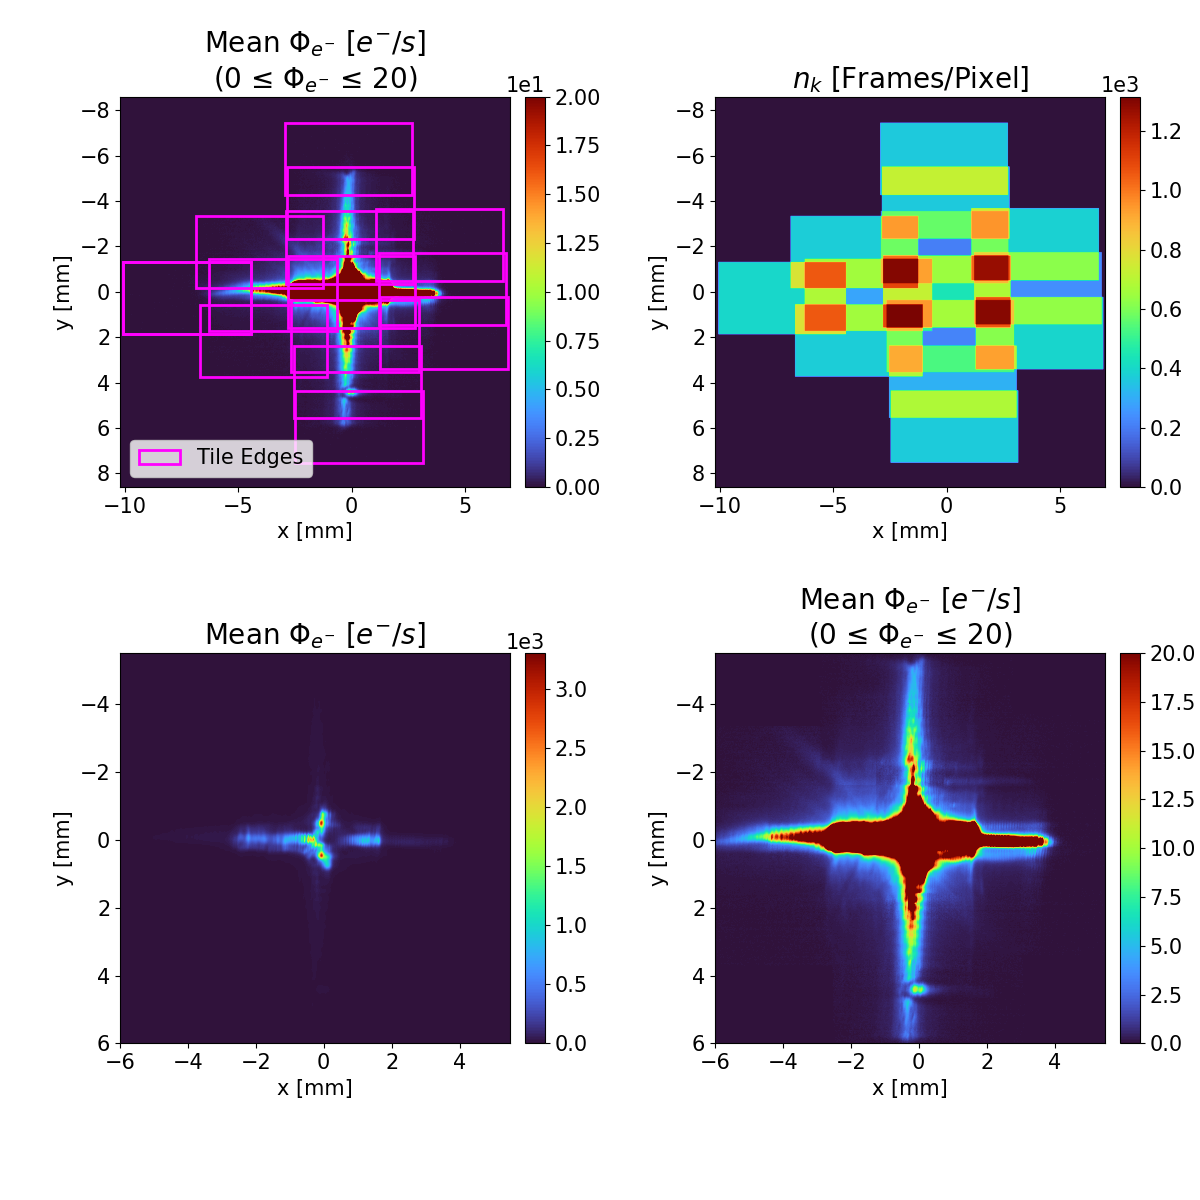

In [23]:
PercentErrorStr = str(round(PercentError*100,3))
GainPercentErrorStr = str(round(GainPercentError*100,3))

#print("Check Value1 = " +str(round(np.amin(SumDarkSignalsMosaic),2)) + " (should be -181 not -757)")
print("Check Value = " +str(round(np.amin(MeanDarkSubFluxMosaic),3)) + " (should be -7.297 not -95.9)")

print("")
print("Mean Flux: " + "{:e}".format(MeanFlux) + " [e-/s]")
print("Sigma1: " + "{:e}".format(Sigma1))
print("Sigma2: " + "{:e}".format(Sigma2))
print("Error on Mean Flux (Before Alignment Uncertainty): " + "{:e}".format(ErrMeanFlux) + " [e-/s]")
print("Percent Error (Before Alignment Uncertainty): " + PercentErrorStr + "%")
print("For Sanity Check, Percent Error on Gain: " + GainPercentErrorStr + "%")

#----------------------------------------------------------------------------------------------------------------------

Mosaic = MeanDarkSubFluxMosaic

#Making the Mosaic bigger in x
x_max_pixels = np.shape(Mosaic)[1]
y_max_pixels = np.shape(Mosaic)[0]
NewMosaic = np.zeros((y_max_pixels,x_max_pixels+2000))
NewMosaic[0:Mosaic.shape[0], 0:Mosaic.shape[1]] = Mosaic
Mosaic = NewMosaic

#Making n_k bigger in x
x_max_pixels = np.shape(n_k)[1]
y_max_pixels = np.shape(n_k)[0]
new_n_k = np.zeros((y_max_pixels,x_max_pixels+2000))
new_n_k[0:n_k.shape[0], 0:n_k.shape[1]] = n_k

#<Putting the axes of the plots in mm from center>
um_per_pixel = 2.9
x_center = TranslateX_Dict['X0_Y0'] + (DimX/2)
y_center = TranslateY_Dict['X0_Y0'] + (DimY/2)

x_min_mm = -1*x_center*um_per_pixel*0.001
y_min_mm = -1*y_center*um_per_pixel*0.001

x_max_pixels = np.shape(Mosaic)[1]
y_max_pixels = np.shape(Mosaic)[0]

x_max_mm = (x_max_pixels - x_center)*um_per_pixel*0.001
y_max_mm = (y_max_pixels - y_center)*um_per_pixel*0.001

extent = [x_min_mm, x_max_mm, y_min_mm, y_max_mm]
extent = [x_min_mm, x_max_mm, y_max_mm, y_min_mm]
#</>

f, ax = plt.subplots(2, 2)

#Plotting Top Left
im1 = ax[0,1].imshow(new_n_k, cmap='turbo', extent=extent)
divider1 = make_axes_locatable(ax[0,1])
cax1 = divider1.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))
ax[0,1].set_xlabel('x [mm]')
ax[0,1].set_ylabel('y [mm]')
ax[0,1].set_title("$n_{k}$ [Frames/Pixel]", loc = 'center')
#ax[0,0].set_xlim([1300,7300])
#ax[0,0].set_ylim([830,6830])
ax[0,1].axis('equal')
#ax[0,0].set(xlim=(-10.2,10.2), ylim=(10.2,-10.2))
ax[0,1].set(xlim=(-10.2,7), ylim=(8.6,-8.6))
#plt.subplots_adjust(hspace = 0.35)

#Plotting Top Right
im2 = ax[0,0].imshow(Mosaic, cmap='turbo',extent=extent, vmin = 0, vmax = 20)
divider2 = make_axes_locatable(ax[0,0])
cax2 = divider2.append_axes("right", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.formatter.set_powerlimits((0, 0))
#cbar1.formatter.set_useMathText(True)
for SetName in SetNamesList:
    Coords = -1*CoordsDict[SetName]
    
    MosaicX = Coords[0]
    MosaicY = Coords[1]
    
    if SetName in TranslateX_Dict:
        TranslateX = TranslateX_Dict[SetName]
        TranslateY = TranslateY_Dict[SetName]
    else:
        TranslateX = int(((MosaicX/2) + 2)*DimX)
        TranslateY = int((MosaicY + 3)*DimY)
            
    ROI = [TranslateX, TranslateX + DimX -1, TranslateY, TranslateY + DimY -1]
    ROImm = [(ROI[0]-x_center)*um_per_pixel*0.001,(ROI[1]-x_center)*um_per_pixel*0.001,(ROI[2]-y_center)*um_per_pixel*0.001,(ROI[3]-y_center)*um_per_pixel*0.001] 
    xROI, yROI = ROItoPoints(ROImm)

    ax[0,0].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2)
ax[0,0].fill(xROI, yROI, facecolor='none', edgecolor='magenta', linewidth=2, label = "Tile Edges")
ax[0,0].set_xlabel('x [mm]')
ax[0,0].set_ylabel('y [mm]')
#ax[0,1].set_title("Mean $\Phi_{e^{-}}$ [$e^{-}/s$]", loc = 'center')
ax[0,0].set_title(r"Mean $\Phi_{e^{-}}$ [$e^{-}/s$]"
               "\n" r"($0\ ≤\  \Phi_{e^{-}}\ ≤\ 20$)", loc = 'center')
#ax[0,1].set_xlim([1300,7300])
#ax[0,1].set_ylim([830,6830])
#ax[0,1].set_xlim([-10.1,10.1])
#ax[0,1].set_ylim([-10.1,10.1])
ax[0,0].axis('equal')
#ax[0,0].set(xlim=(-10.2,10.2), ylim=(10.2,-10.2))
ax[0,0].set(xlim=(-10.2,7), ylim=(8.6,-8.6))
ax[0,0].legend(loc='lower left')

#Plotting Bottom Left
im2 = ax[1,0].imshow(Mosaic, cmap='turbo', extent = extent)
divider2 = make_axes_locatable(ax[1,0])
cax2 = divider2.append_axes("right", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.formatter.set_powerlimits((0, 0))
#cbar1.formatter.set_useMathText(True)
ax[1,0].set_xlabel('x [mm]')
ax[1,0].set_ylabel('y [mm]')
ax[1,0].set_title("Mean $\Phi_{e^{-}}$ [$e^{-}/s$]", loc = 'center')
#ax[1,0].set_xlim([1300,7300])
#ax[1,0].set_ylim([830,6830])
ax[1,0].axis('equal')
#ax[1,0].set(xlim=(-7.5,7.5), ylim=(7.5,-7.5))
ax[1,0].set(xlim=(-6,5.5), ylim=(6,-5.5))


#Plotting Bottom Right
im2 = ax[1,1].imshow(Mosaic, cmap='turbo', extent = extent, vmin = 0, vmax = 20)
divider2 = make_axes_locatable(ax[1,1])
cax2 = divider2.append_axes("right", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2)
#cbar2.formatter.set_powerlimits((0, 0))
#cbar1.formatter.set_useMathText(True)
ax[1,1].set_xlabel('x [mm]')
ax[1,1].set_ylabel('y [mm]')
ax[1,1].set_title(r"Mean $\Phi_{e^{-}}$ [$e^{-}/s$]"
               "\n" r"($0\ ≤\  \Phi_{e^{-}}\ ≤\ 20$)", loc = 'center')

#ax[1,1].set_xlim([1300,7300])
#ax[1,1].set_ylim([830,6830])
ax[1,1].axis('equal')
#ax[1,1].set(xlim=(-7.5,7.5), ylim=(7.5,-7.5))
ax[1,1].set(xlim=(-6,5.5), ylim=(6,-5.5))

#plt.subplots_adjust(hspace = 0.35)
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()
#plt.savefig("MosaicTestPlot1a.png", dpi=200,bbox_inches='tight')
#Include projected extent of the d3 photodiode

### Finding the Contribution from Alignment Uncertainty (Sigma3)

In [26]:
#Functionalizing the Mean Mosaic Flux Calculation (and streamlining for speeed)
def FindMosaicMeanFlux(MosaicDimY,MosaicDimX,SetNamesList,DictList,CoordsDict,TranslateX_Dict,TranslateY_Dict,verbose=True):
    
    NumFrameCountDict, HotsArrayDict, SumSignalFrameDict, SumDarkSubSignalFrameDict  = DictList
    
    n_k = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,NumFrameCountDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)
    HotsMosaic = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,HotsArrayDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)
    SumDarkSubSignalMosaic = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,SumDarkSubSignalFrameDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)
    
    # WeightedSumSignalMosaic is made from non-dark subtracted sum signal mosaic
    divide_n_k = np.zeros(np.shape(n_k))
    divide_n_k = np.where(n_k < 1, 1, n_k)
    
    #Getting Mean Flux

    #Zero hot pixels
    SumDarkSubSignalMosaic = np.where(HotsMosaic > 0, 0, SumDarkSubSignalMosaic)

    #Get mean (per frame) dark subtracted signal by dividing by n_k (the number of frames summed to make each pixel's sum signal)
    MeanDarkSubFluxMosaic = SumDarkSubSignalMosaic/divide_n_k
    #In this case it's reasonable to say that all sets have the same exposure time, and that this exposure time is to within less
    #than 10^-6 seconds of exactly 1 second. So, the mean per frame is also the mean flux.
    
    #Finding the Mean Flux
    MeanFlux = np.sum(MeanDarkSubFluxMosaic)
    
    return MeanFlux

In [27]:
import copy

def NudgeSetNameTile(SetName,NudgeX,NudgeY,TranslateX_Dict,TranslateY_Dict):
    
    TranslateX = TranslateX_Dict[SetName]
    TranslateY = TranslateY_Dict[SetName]
    
    NewTranslateX = TranslateX_Dict[SetName] + NudgeX
    NewTranslateY = TranslateY_Dict[SetName] + NudgeY
    
    NewTranslateX_Dict = copy.deepcopy(TranslateX_Dict)
    NewTranslateY_Dict = copy.deepcopy(TranslateY_Dict)
    
    NewTranslateX_Dict.update({SetName:NewTranslateX})
    NewTranslateY_Dict.update({SetName:NewTranslateY})
    
    return NewTranslateX_Dict, NewTranslateY_Dict

def WiggleSetNameTile(SetName,DictList,TranslateX_Dict,TranslateY_Dict):
    
    MosaicDimY = 7
    MosaicDimX = 4
    
    BaselineMeanFlux =  FindMosaicMeanFlux(MosaicDimY,MosaicDimX,SetNamesList,DictList,CoordsDict,TranslateX_Dict,TranslateY_Dict)

    NudgesList = [-20,-16,-12,-8,-4,0,4,8,12,16,20]
    #Can nudge plus or minus 20 along x and y skipping every other number to save time
    
    MeanFluxesList = []
    ErrMeanFluxesList = []
    
    for NudgeX in tqdm(NudgesList):
        print("Nudge X: " + str(NudgeX))
        for NudgeY in tqdm(NudgesList):
            NewTranslateX_Dict, NewTranslateY_Dict = NudgeSetNameTile(SetName,NudgeX,NudgeY,TranslateX_Dict,TranslateY_Dict)
            
            MeanFlux =  FindMosaicMeanFlux(MosaicDimY,MosaicDimX,SetNamesList,DictList,CoordsDict,NewTranslateX_Dict,NewTranslateY_Dict)
    
            MeanFluxesList.append(MeanFlux)
            
    MeanFluxesArray = np.array(MeanFluxesList)
    
    FluxDifferenceArray = MeanFluxesArray - BaselineMeanFlux
    
    return MeanFluxesArray, FluxDifferenceArray

#### Do not run this cell unless you have something like 30 hours to waste.

In [ ]:
#Wiggle Everything
'''
SetNamesList = SetNamesList
DictList = [NumFrameCountDict,HotsArrayDict,SumSignalFrameDict,SumDarkSubSignalFrameDict]

for SetName in SetNamesList:
    
    datadirectory = 'SteadyStateDataSets/' + SetName
    
    MeanFluxesArray, FluxDifferenceArray = WiggleSetNameTile(SetName,DictList,TranslateX_Dict,TranslateY_Dict)
    
    np.savetxt(datadirectory + '/MeanFluxesWiggleArray' + '.csv', MeanFluxesArray, delimiter=',')
    np.savetxt(datadirectory + '/FluxDifferenceWiggleArray' + '.csv', FluxDifferenceArray, delimiter=',')
    
    print("Completed and Saved for " + SetName)
'''

In [28]:
#Loading in Wiggle Arrays and making Dictionaries

MeanFluxesWiggleDict = {}
FluxDifferenceWiggleDict = {}

for SetName in SetNamesList:
    
    LoadDirectory = 'SteadyStateDataSets/' + SetName
    
    MeanFluxesWiggleArray = np.loadtxt(LoadDirectory + '/MeanFluxesWiggleArray' + '.csv', delimiter=',')
    FluxDifferenceWiggleArray = np.loadtxt(LoadDirectory + '/FluxDifferenceWiggleArray' + '.csv', delimiter=',')
    
    MeanFluxesWiggleDict.update({SetName:MeanFluxesWiggleArray})
    FluxDifferenceWiggleDict.update({SetName:FluxDifferenceWiggleArray})

In [30]:
DictList = [NumFrameCountDict,HotsArrayDict,SumSignalFrameDict,SumDarkSubSignalFrameDict]
BaselineMeanFlux = FindMosaicMeanFlux(MosaicDimY,MosaicDimX,SetNamesList,DictList,CoordsDict,TranslateX_Dict,TranslateY_Dict)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [31]:
MeanFractionalFluxDict = {}
StdFractionalFluxDict = {}

for SetName in SetNamesList:
    
    MeanFluxesWiggleArray = MeanFluxesWiggleDict[SetName] #Mean Total Mosaic fluxes for a given nudge of tile SetName(notperpix)
    FluxDifferenceWiggleArray = FluxDifferenceWiggleDict[SetName] #Difference betwen flux and default un-nudged flux
    
    #Find standard deviation of fractional fluxes
    FractionalFluxesArray = MeanFluxesWiggleArray/BaselineMeanFlux
    
    MeanFractionalFlux = np.mean(FractionalFluxesArray)
    StdFractionalFlux = np.std(FractionalFluxesArray)
    
    MeanFractionalFluxDict.update({SetName:MeanFractionalFlux})
    StdFractionalFluxDict.update({SetName:StdFractionalFlux})
    
    print("")
    print(SetName)
    print("Mean Fractional Flux: " + str(round(MeanFractionalFlux,3)))
    print("Standard Deviation Fractional Flux: " + str(round(StdFractionalFlux,3)))


X0_Y0
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.002

X0_YM1
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.005

X0_YM2
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.0

X0_YM3
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.0

X0_YP1
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.004

X0_YP2
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.0

X0_YP3
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.0

XM2_Y0
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.002

XM2_YM1
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.001

XM2_YP1
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.0

XP2_Y0
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.004

XP2_YM1
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.0

XP2_YP1
Mean Fractional Flux: 1.0
Standard Deviation Fractional Flux: 0.003

XP4_Y0
Mean Fraction

In [32]:
#Determining Sigma3 by treating the errors as independent and taking the square root of the quadrature sum
QuadSum = 0
for SetName in SetNamesList:
    QuadSum += (BaselineMeanFlux*StdFractionalFluxDict[SetName])**2
Sigma3 = math.sqrt(QuadSum)

## Final Results for Mosaic Photoelectron Flux and Error

In [36]:
ErrMeanFluxFinal = math.sqrt((Sigma1**2) + (Sigma2**2) + (Sigma3**2)) 
PercentError = ErrMeanFluxFinal/MeanFlux 
GainPercentError = SigmaGain/Gain

print("")
print("Mean Flux: " + "{:e}".format(MeanFlux) + " [e-/s]")
print("Error on Mean Flux: " + "{:e}".format(ErrMeanFluxFinal) + " [e-/s]")
#print("Baseline Mean Flux: " + "{:e}".format(BaselineMeanFlux) + " [e-/s]")
print("Sigma1: " + "{:e}".format(Sigma1) + " [e-/s] (Propogated error from CMOS gain uncertainty)")
print("Sigma2: " + "{:e}".format(Sigma2) + " [e-/s] (Gehrels counting statistics error)")
print("Sigma3: " + "{:e}".format(Sigma3) + " [e-/s] (Alignment uncertainty error)")

print("Percent Error: " + PercentErrorStr + "%")
print("")
print("For Sanity Check, Percent Error on Gain: " + GainPercentErrorStr + "%")


Mean Flux: 2.029951e+08 [e-/s]
Error on Mean Flux: 7.940528e+06 [e-/s]
Sigma1: 7.739380e+06 [e-/s] (Propogated error from CMOS gain uncertainty)
Sigma2: 1.157923e+03 [e-/s] (Gehrels counting statistics error)
Sigma3: 1.775945e+06 [e-/s] (Alignment uncertainty error)
Percent Error: 3.813%

For Sanity Check, Percent Error on Gain: 2.877%


###  Sanity Check the Angular Extents

In [ ]:
# Making Tile Overlap Mosaic
NumTileOverlapDict = {}

for SetName in tqdm(SetNamesList):
    NumTileFrame = np.zeros((DimY,DimX)) + 1 # Each tile is an array of just ones. When they're summed,
    #the mosaic with be the number of overlaping tiles at a given position.
    NumTileOverlapDict.update({SetName:NumTileFrame})

    #Making n_k mosaic array (the mosaic of how many times a pixel in the mosaic has been counted)

MosaicDimY = 7
MosaicDimX = 4
SetNamesList = SetNamesList
FramesDict = NumTileOverlapDict
CoordsDict = CoordsDict
TranslateX_Dict = TranslateX_Dict_GD4
TranslateY_Dict = TranslateY_Dict_GD4

n_tile_k = MakeSumMosaic(MosaicDimY,MosaicDimX,SetNamesList,FramesDict,CoordsDict,TranslateX_Dict,TranslateY_Dict)

            
f, ax = plt.subplots(1, 1)
im1 = ax.imshow(n_tile_k, cmap='turbo')
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.formatter.set_powerlimits((0, 0))
ax.set_xlabel('Pixel x')
ax.set_ylabel('Pixel y')
ax.set_title("$n_{k}$ Mosaic", loc = 'center')
plt.subplots_adjust(hspace = 0.35)
figure = plt.gcf()
figure.set_size_inches(8, 8)
#SaveString = "Mean_Flux_Mosaic_A.png"
#plt.savefig(SaveString, dpi=750,bbox_inches='tight')
plt.show()


#Determining the Minimum x
MinimumX = 0
for i in range(np.shape(n_tile_k)[1]):  
    ThePixelValue = n_tile_k[4000,i]
    if ThePixelValue == 1:
        MinimumX = i
        break
print(MinimumX)

MaximumX = 0
for i in reversed(range(np.shape(n_tile_k)[1])):
    ThePixelValue = n_tile_k[4600,i]
    if ThePixelValue == 1:
        MaximumX = i
        break
print(MaximumX)


MinimumY = 0
for i in range(np.shape(n_tile_k)[0]):
    ThePixelValue = n_tile_k[i,4600]
    if ThePixelValue == 1:
        MinimumY = i
        break
print(MinimumY)

MaximumY = 0
for i in reversed(range(np.shape(n_tile_k)[0])):
    ThePixelValue = n_tile_k[i,4600]
    if ThePixelValue == 1:
        MaximumY = i
        break
print(MaximumY)

xLength = ((MaximumX - MinimumX)*2.9*1e-6)/1e-3
yLength = ((MaximumY - MinimumY)*2.9*1e-6)/1e-3

print("Mosaic Dimension X: " + str(xLength) + " mm")
print("Mosaic Dimension Y: " + str(yLength) + " mm")

#need minimum x distance from center

L1 = 211 #pm19 [mm]
L2 = 924 #pm25 mm
pdLength = 10.03

MosaicAngularExtent = math.atan((xLength/2)/L2)*2
PhotodiodeAngularExtent = math.atan((pdLength/2)/L1)*2

MosaicAngularExtentDeg = math.atan((xLength/2)/L2)*2*(360/(2*pi))
PhotodiodeAngularExtentDeg = math.atan((pdLength/2)/L1)*2*(360/(2*pi))

print("")
print("Mosaic Angular Extent: " + str(round(MosaicAngularExtent,3)) + " radians")
print("Photodiode Angular Extent: " + str(round(PhotodiodeAngularExtent,3)) + " radians")
print("")
print("Mosaic Angular Extent: " + str(round(MosaicAngularExtentDeg,3)) + " degrees")
print("Photodiode Angular Extent: " + str(round(PhotodiodeAngularExtentDeg,3)) + " degrees")